# Graph ConvNet for cosmology: part of sphere classification (whole data, smoothing + noise)

[Nathanaël Perraudin](http://perraudin.info), [Michaël Defferrard](http://deff.ch), Tomasz Kacprzak

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tqdm import tqdm_notebook
import healpy as hp
import pygsp

from scnn import models, utils
from scnn.data import LabeledDatasetWithNoise, LabeledDataset

In [3]:
plt.rcParams['figure.figsize'] = (17, 5)

In [18]:
Nside = 1024
order = 4  # 1,2,4,8 correspond to 12,48,192,768 parts of the sphere.
sigma_noise = 2
sigma = 3
EXP_NAME = '40sim_{}sides_1arcmin_{}noise_{}order_{}sigma_test3'.format(Nside, sigma_noise, order,sigma)
data_path = 'data/same_psd/'

## 1 Load spherical data 

Load the different maps and prepare some dataset.

In [19]:
# ds1 = []
# ds2 = []

# for filename in tqdm_notebook(os.listdir(data_path)):
    
#     if not filename.endswith('fits'):
#         continue
        
#     filepath = os.path.join(data_path, filename)
#     img = hp.read_map(filepath, verbose=False)
#     img = hp.reorder(img, r2n=True)
#     img = hp.ud_grade(img, nside_out=Nside, order_in='NESTED')
    
#     if '0p26' in filename:
#         ds1.append(img)
#     elif '0p31' in filename:
#         ds2.append(img)

## 2 Data preparation

Here we apply the preprocessing steps.
1. Smooth with a radius of 1 arcmin.
2. Cut the sphere into samples.
3. Add noise.
4. Split the data in training and test sets.

### 2.1 Data smoothing

In [20]:
# def arcmin2rad(x):
#     return x / 60 / 360 * 2 * np.pi

# def gaussian_smoothing(sig, sigma, nest=True):
#     if nest:
#         sig = hp.reorder(sig, n2r=True)
#     smooth = hp.sphtfunc.smoothing(sig, sigma=arcmin2rad(sigma))
#     if nest:
#         smooth = hp.reorder(smooth, r2n=True)
#     return smooth

In [21]:
# ds1 = [gaussian_smoothing(el, 1, nest=True).astype(np.float32) for el in ds1]
# ds2 = [gaussian_smoothing(el, 1, nest=True).astype(np.float32) for el in ds2]

### 2.2 Samples creation

We here create samples by dividing the two complete spheres in patches (based on healpix sampling).

In [22]:
ds1 = np.load(data_path+'smoothed_class1_sigma{}.npz'.format(sigma))['arr_0']
ds2 = np.load(data_path+'smoothed_class2_sigma{}.npz'.format(sigma))['arr_0']
datasample = dict()
datasample['class1'] = np.vstack([utils.hp_split(el, order=order) for el in ds1])
datasample['class2'] = np.vstack([utils.hp_split(el, order=order) for el in ds2])
del ds1
del ds2

print('The data is of shape {}'.format(datasample['class1'].shape))

The data is of shape (3840, 65536)


### 2.3 Normalization and train / test split 

Let us split the data into training and testing sets. The raw data is stored into `x_raw` and the histograms into `x_trans`. As a transformation, we cannot use the power spectrum density. Hence we do an histogram of the data.

In [23]:
# Normalize and transform the data, i.e. extract features.
x_raw = np.vstack((datasample['class1'], datasample['class2']))
x_raw_std = np.std(x_raw)
x_raw = x_raw / x_raw_std  # Apply some normalization (The mean is already 0)
rs = np.random.RandomState(0)
x_noise = x_raw + sigma_noise * rs.normal(0, 1, size=x_raw.shape)
cmin = np.min(x_raw)
cmax = np.max(x_raw)
x_hist = utils.histogram(x_noise, cmin, cmax)
x_trans = preprocessing.scale(x_hist)

# Create the label vector.
labels = np.zeros([x_raw.shape[0]], dtype=int)
labels[len(datasample['class1']):] = 1

# Random train / test split.
ret = train_test_split(x_raw, x_trans, x_noise, labels, train_size=0.8, shuffle=True, random_state=0)
x_raw_train, x_raw_validation, x_trans_train, x_trans_validation, x_noise_train, x_noise_validation, labels_train, labels_validation = ret

print('Class 1 VS class 2')
print('  Training set: {} / {}'.format(np.sum(labels_train==0), np.sum(labels_train==1)))
print('  Validation set: {} / {}'.format(np.sum(labels_validation==0), np.sum(labels_validation==1)))

/home/nati/.virtualenvs/scnn-py3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Class 1 VS class 2
  Training set: 3092 / 3052
  Validation set: 748 / 788


## 3  Classification using SVM

Let us test classify our data using an SVM classifier.

This is not the code used to report results in the article. We use the augmented dataset and the computation is performed in a different notebook. Nevertheless, the result give us an idea of the performance of the histogram features.

In [24]:
clf = SVC(kernel='linear')
# clf.fit(np.vstack([x_trans_train, utils.histogram(x_raw_train, cmin, cmax)]),
#         np.concatenate([labels_train, labels_train]))
clf.fit(x_trans_train, labels_train) 

utils.print_error(clf, x_trans_train, labels_train, 'Training')
utils.print_error(clf, x_trans_validation, labels_validation, 'Validation')

Training error: 26.04%
Validation error: 28.65%


0.2864583333333333

In [ ]:
psd_raw = utils.psd_unseen(x_raw)

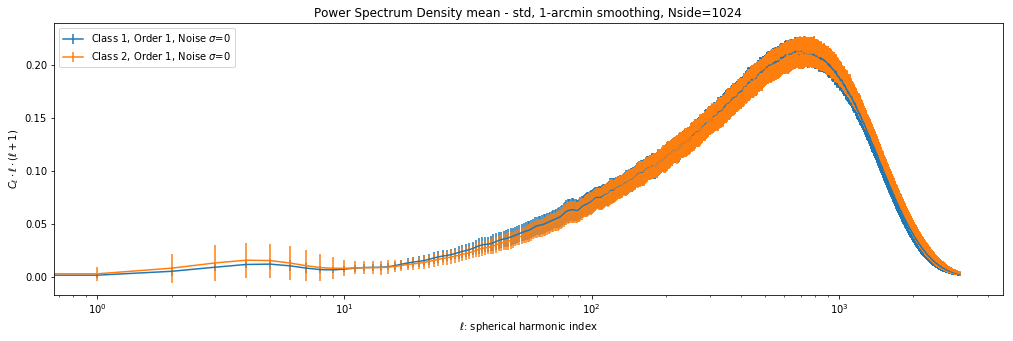

In [38]:
nsample1 = len(datasample['class1'])
mean_raw_psds1 = np.mean(psd_raw[:nsample1],axis=0)
mean_raw_psds2 = np.mean(psd_raw[nsample1:],axis=0)
std_raw_psds1 = np.std(psd_raw[:nsample1],axis=0)
std_raw_psds2 = np.std(psd_raw[nsample1:],axis=0)

l = np.array(range(len(mean_raw_psds1)))
plt.errorbar(l,mean_raw_psds1*l*(l+1), yerr=std_raw_psds1*l*(l+1), label='Class {}, Order {}, Noise $\sigma$={}'.format(1,order, 0))
plt.errorbar(l,mean_raw_psds2*l*(l+1), yerr=std_raw_psds2*l*(l+1), label='Class {}, Order {}, Noise $\sigma$={}'.format(2,order, 0))

plt.legend();
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\ell$: spherical harmonic index')
plt.ylabel('$C_\ell \cdot \ell \cdot (\ell+1)$')
plt.title('Power Spectrum Density mean - std, {}-arcmin smoothing, Nside=1024'.format(sigma));

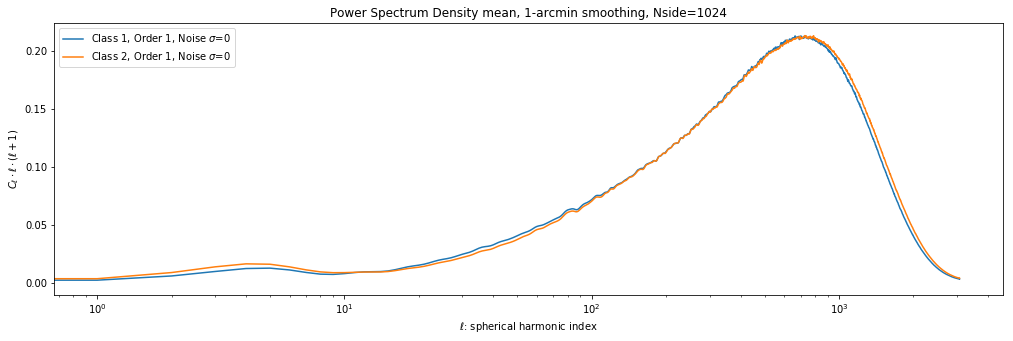

In [37]:
l = np.array(range(len(mean_raw_psds1)))
plt.errorbar(l,mean_raw_psds1*l*(l+1), label='Class {}, Order {}, Noise $\sigma$={}'.format(1,order, 0))
plt.errorbar(l,mean_raw_psds2*l*(l+1), label='Class {}, Order {}, Noise $\sigma$={}'.format(2,order, 0))
plt.legend();
# plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\ell$: spherical harmonic index')
plt.ylabel('$C_\ell \cdot \ell \cdot (\ell+1)$')
plt.title('Power Spectrum Density mean, 1-arcmin smoothing, Nside=1024');

In [ ]:
psd_noise = utils.psd_unseen(x_noise)

In [ ]:
mean_noise_psds1 = np.mean(np.stack(psds_noise[:nsample1]),axis=0)
mean_noise_psds2 = np.mean(np.stack(psds_noise[nsample1:]),axis=0)
std_noise_psds1 = np.sqrt(np.var(np.stack(psds_noise[:nsample1]),axis=0))
std_noise_psds2 = np.sqrt(np.var(np.stack(psds_noise[nsample1:]),axis=0))

plt.errorbar(l,mean_noise_psds1*l*(l+1), yerr=std_noise_psds1*l*(l+1), label='Class {}, Order {}, Noise $\sigma$={}'.format(1,order, sigma_noise))
plt.errorbar(l,mean_noise_psds2*l*(l+1), yerr=std_noise_psds2*l*(l+1), label='Class {}, Order {}, Noise $\sigma$={}'.format(2,order, sigma_noise))


plt.legend();
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\ell$: spherical harmonic index')
plt.ylabel('$C_\ell \cdot \ell \cdot (\ell+1)$')
plt.title('Power Spectrum Density mean, 1-arcmin smoothing, Nside=1024');

### 3.1 Histogram features visualization

Let us first plot the mean and then each feature individually.

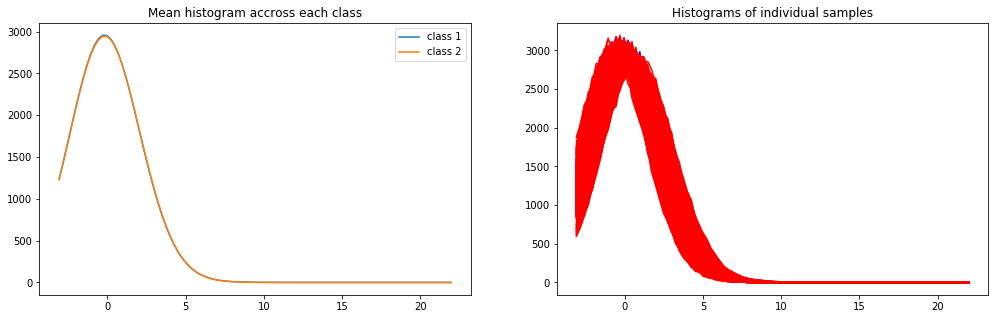

In [25]:
x = np.linspace(cmin, cmax, num=x_hist.shape[1])
fig, axes = plt.subplots(1, 2)
np.linspace(cmin, cmax, num=x_hist.shape[0])
axes[0].plot(x, np.mean(x_hist[labels==0], axis=0), label='class 1')
axes[0].plot(x, np.mean(x_hist[labels==1], axis=0), label='class 2')
axes[0].legend()
axes[0].set_title('Mean histogram accross each class')

axes[1].plot(x, x_hist[labels==0].T, 'b')
axes[1].plot(x, x_hist[labels==1].T, 'r')
axes[1].set_title('Histograms of individual samples');

## 4 Classification using a spherical CNN

Let us now classify our data using a spherical convolutional neural network.

In [26]:
if order==4:
    nsides = [Nside, Nside//2, Nside//4, min(Nside//8, 128)]
elif order==2:
    nsides = [Nside, Nside//2, Nside//4, Nside//8, min(Nside//16, 128)]
elif order==1:
    nsides = [Nside, Nside//2, Nside//4, Nside//8, Nside//16, min(Nside//32, 64)]
else:
    raise ValueError('No parameters for this value of order.')

# nsides = [2048, 1024, 256, 64]
# nsides = [128, 32, 16]
print('#sides: {}'.format(nsides))

indexes = utils.nside2indexes(nsides, order)

#sides: [1024, 512, 256, 128]


In [35]:

C = 2  # number of class
ntrain = len(x_noise_train)

params = dict()
params['dir_name'] = EXP_NAME

params['eval_frequency'] = 10

# Building blocks.
params['brelu'] = 'b1relu'  # Activation.
params['pool'] = 'mpool1'  # Pooling.

# Architecture.
params['nsides'] = nsides  # Sizes of the laplacians are 12 * nsides**2.
params['indexes'] = indexes  # Sizes of the laplacians are 12 * nsides**2.
if order == 4:
    params['num_epochs'] = 50
    params['batch_size'] = 20        
    params['F'] = [40, 160, 320,
                   20]  # Number of graph convolutional filters.
    params['K'] = [10, 10, 10, 10]  # Polynomial orders.
    params['batch_norm'] = [True, True, True, True]  # Batch norm

elif order == 2:
    params['num_epochs'] = 100
    params['batch_size'] = 15
    params['F'] = [10, 80, 320, 40,
                   10]  # Number of graph convolutional filters.
    params['K'] = [10, 10, 10, 10, 10]  # Polynomial orders.
    params['batch_norm'] = [True, True, True, True, True]  # Batch norm
elif order == 1:
    params['num_epochs'] = 200
    params['batch_size'] = 10
    params['F'] = [10, 40, 160, 40, 20,
                   10]  # Number of graph convolutional filters.
    params['K'] = [10, 10, 10, 10, 10, 10]  # Polynomial orders.
    params['batch_norm'] = [True, True, True, True, True,
                            True]  # Batch norm
else:
    raise ValueError('No parameter for this value of order.')

params['M'] = [100, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['decay_rate'] = 0.98
params['regularization'] = 1e-4
params['dropout'] = 0.5
params['learning_rate'] = 1e-4
params['momentum'] = 0.9
params['adam'] = True
params['decay_steps'] = 153.6

model = models.scnn(**params)

NN architecture
  input: M_0 = 65536
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 65536 * 10 / 4 = 163840
    weights: F_0 * F_1 * K_1 = 1 * 10 * 10 = 100
    biases: F_1 = 10
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 16384 * 40 / 4 = 163840
    weights: F_1 * F_2 * K_2 = 10 * 40 * 10 = 4000
    biases: F_2 = 40
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 4096 * 320 / 4 = 327680
    weights: F_2 * F_3 * K_3 = 40 * 320 * 10 = 128000
    biases: F_3 = 320
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 1024 * 20 / 1 = 20480
    weights: F_3 * F_4 * K_4 = 320 * 20 * 10 = 64000
    biases: F_4 = 20
  layer 5: fc1
    representation: M_5 = 100
    weights: M_4 * M_5 = 20480 * 100 = 2048000
    biases: M_5 = 100
  layer 6: logits (softmax)
    representation: M_6 = 2
    weights: M_5 * M_6 = 100 * 2 = 200
    biases: M_6 = 2
---------
Variables: name (type shape) [size]
---------
Total size of variables: 0
Total bytes of variables: 0


In [36]:
training = LabeledDatasetWithNoise(x_raw_train, labels_train, start_level=0, end_level=sigma_noise, nit=len(labels_train) // 5 )
# training = LabeledDatasetWithNoise(x_raw_train, labels_train, start_level=0, end_level=sigma_noise, nit=50)
# training = LabeledDataset(x_noise_train, labels_train)
validation = LabeledDataset(x_noise_validation, labels_validation)

In [46]:
len(labels_train) / 40

153.6

With the current setting, the training data will reach the maximum level of noise after one epoch or two epochs. Hence, the validation error will start decreasing after one or two epoch.

In [38]:
# Cleanup before running again.
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

In [39]:
accuracy, loss, t_step = model.fit(training, validation)

step 10 / 7680 (epoch 0.07 / 50):
  learning_rate = 1.00e-04, loss_average = 4.27e+00
  validation accuracy: 50.46 (775 / 1536), f1 (weighted): 46.77, loss: 3.10e+00
  time: 17s (wall 24s)
step 20 / 7680 (epoch 0.13 / 50):
  learning_rate = 1.00e-04, loss_average = 3.72e+00


/home/nati/.virtualenvs/scnn-py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 51.30 (788 / 1536), f1 (weighted): 34.79, loss: 1.30e+01
  time: 33s (wall 47s)
step 30 / 7680 (epoch 0.20 / 50):
  learning_rate = 1.00e-04, loss_average = 2.93e+00
  validation accuracy: 51.30 (788 / 1536), f1 (weighted): 34.79, loss: 9.65e+00
  time: 48s (wall 69s)
step 40 / 7680 (epoch 0.26 / 50):
  learning_rate = 1.00e-04, loss_average = 2.24e+00
  validation accuracy: 51.30 (788 / 1536), f1 (weighted): 34.79, loss: 1.83e+01
  time: 64s (wall 92s)
step 50 / 7680 (epoch 0.33 / 50):
  learning_rate = 1.00e-04, loss_average = 1.97e+00
  validation accuracy: 51.30 (788 / 1536), f1 (weighted): 34.79, loss: 1.49e+01
  time: 79s (wall 114s)
step 60 / 7680 (epoch 0.39 / 50):
  learning_rate = 1.00e-04, loss_average = 1.70e+00
  validation accuracy: 51.30 (788 / 1536), f1 (weighted): 34.79, loss: 2.07e+01
  time: 94s (wall 137s)
step 70 / 7680 (epoch 0.46 / 50):
  learning_rate = 1.00e-04, loss_average = 1.63e+00
  validation accuracy: 51.30 (788 / 1536), f1 (weight

  validation accuracy: 51.30 (788 / 1536), f1 (weighted): 34.79, loss: 3.82e+01
  time: 696s (wall 1014s)
step 460 / 7680 (epoch 2.99 / 50):
  learning_rate = 9.04e-05, loss_average = 1.24e+00
  validation accuracy: 51.30 (788 / 1536), f1 (weighted): 34.79, loss: 3.87e+01
  time: 711s (wall 1036s)
step 470 / 7680 (epoch 3.06 / 50):
  learning_rate = 8.86e-05, loss_average = 1.30e+00
  validation accuracy: 51.30 (788 / 1536), f1 (weighted): 34.79, loss: 3.48e+01
  time: 726s (wall 1058s)
step 480 / 7680 (epoch 3.12 / 50):
  learning_rate = 8.86e-05, loss_average = 1.21e+00
  validation accuracy: 51.30 (788 / 1536), f1 (weighted): 34.79, loss: 3.54e+01
  time: 742s (wall 1081s)
step 490 / 7680 (epoch 3.19 / 50):
  learning_rate = 8.86e-05, loss_average = 1.28e+00
  validation accuracy: 51.30 (788 / 1536), f1 (weighted): 34.79, loss: 3.22e+01
  time: 757s (wall 1104s)
step 500 / 7680 (epoch 3.26 / 50):
  learning_rate = 8.86e-05, loss_average = 1.25e+00
  validation accuracy: 51.30 (788 /

step 880 / 7680 (epoch 5.73 / 50):
  learning_rate = 8.01e-05, loss_average = 1.34e+00
  validation accuracy: 51.30 (788 / 1536), f1 (weighted): 34.79, loss: 1.57e+01
  time: 1358s (wall 1981s)
step 890 / 7680 (epoch 5.79 / 50):
  learning_rate = 8.01e-05, loss_average = 1.34e+00
  validation accuracy: 51.30 (788 / 1536), f1 (weighted): 34.79, loss: 1.53e+01
  time: 1374s (wall 2003s)
step 900 / 7680 (epoch 5.86 / 50):
  learning_rate = 8.01e-05, loss_average = 1.30e+00
  validation accuracy: 51.30 (788 / 1536), f1 (weighted): 34.79, loss: 1.51e+01
  time: 1389s (wall 2026s)
step 910 / 7680 (epoch 5.92 / 50):
  learning_rate = 8.01e-05, loss_average = 1.33e+00
  validation accuracy: 51.30 (788 / 1536), f1 (weighted): 34.79, loss: 1.42e+01
  time: 1404s (wall 2048s)
step 920 / 7680 (epoch 5.99 / 50):
  learning_rate = 8.01e-05, loss_average = 1.32e+00
  validation accuracy: 51.30 (788 / 1536), f1 (weighted): 34.79, loss: 1.33e+01
  time: 1420s (wall 2070s)
step 930 / 7680 (epoch 6.05 / 

  validation accuracy: 66.28 (1018 / 1536), f1 (weighted): 65.73, loss: 1.38e+00
  time: 2006s (wall 2925s)
step 1310 / 7680 (epoch 8.53 / 50):
  learning_rate = 7.09e-05, loss_average = 1.37e+00
  validation accuracy: 64.45 (990 / 1536), f1 (weighted): 64.24, loss: 1.38e+00
  time: 2021s (wall 2948s)
step 1320 / 7680 (epoch 8.59 / 50):
  learning_rate = 7.09e-05, loss_average = 1.41e+00
  validation accuracy: 67.25 (1033 / 1536), f1 (weighted): 67.20, loss: 1.37e+00
  time: 2036s (wall 2970s)
step 1330 / 7680 (epoch 8.66 / 50):
  learning_rate = 7.09e-05, loss_average = 1.35e+00
  validation accuracy: 66.73 (1025 / 1536), f1 (weighted): 66.73, loss: 1.37e+00
  time: 2052s (wall 2993s)
step 1340 / 7680 (epoch 8.72 / 50):
  learning_rate = 7.09e-05, loss_average = 1.37e+00
  validation accuracy: 64.78 (995 / 1536), f1 (weighted): 64.78, loss: 1.38e+00
  time: 2067s (wall 3015s)
step 1350 / 7680 (epoch 8.79 / 50):
  learning_rate = 7.09e-05, loss_average = 1.39e+00
  validation accuracy:

  validation accuracy: 61.85 (950 / 1536), f1 (weighted): 57.84, loss: 1.40e+00
  time: 2652s (wall 3870s)
step 1730 / 7680 (epoch 11.26 / 50):
  learning_rate = 6.41e-05, loss_average = 1.32e+00
  validation accuracy: 67.51 (1037 / 1536), f1 (weighted): 66.37, loss: 1.36e+00
  time: 2668s (wall 3892s)
step 1740 / 7680 (epoch 11.33 / 50):
  learning_rate = 6.41e-05, loss_average = 1.38e+00
  validation accuracy: 69.21 (1063 / 1536), f1 (weighted): 69.21, loss: 1.33e+00
  time: 2683s (wall 3914s)
step 1750 / 7680 (epoch 11.39 / 50):
  learning_rate = 6.41e-05, loss_average = 1.36e+00
  validation accuracy: 64.19 (986 / 1536), f1 (weighted): 61.64, loss: 1.38e+00
  time: 2699s (wall 3937s)
step 1760 / 7680 (epoch 11.46 / 50):
  learning_rate = 6.41e-05, loss_average = 1.33e+00
  validation accuracy: 62.57 (961 / 1536), f1 (weighted): 59.14, loss: 1.38e+00
  time: 2714s (wall 3960s)
step 1770 / 7680 (epoch 11.52 / 50):
  learning_rate = 6.28e-05, loss_average = 1.32e+00
  validation accur

  validation accuracy: 73.76 (1133 / 1536), f1 (weighted): 73.57, loss: 1.26e+00
  time: 3300s (wall 4814s)
step 2150 / 7680 (epoch 14.00 / 50):
  learning_rate = 5.80e-05, loss_average = 1.24e+00
  validation accuracy: 72.20 (1109 / 1536), f1 (weighted): 72.19, loss: 1.26e+00
  time: 3315s (wall 4837s)
step 2160 / 7680 (epoch 14.06 / 50):
  learning_rate = 5.68e-05, loss_average = 1.28e+00
  validation accuracy: 72.59 (1115 / 1536), f1 (weighted): 72.33, loss: 1.26e+00
  time: 3331s (wall 4859s)
step 2170 / 7680 (epoch 14.13 / 50):
  learning_rate = 5.68e-05, loss_average = 1.22e+00
  validation accuracy: 68.88 (1058 / 1536), f1 (weighted): 67.46, loss: 1.32e+00
  time: 3347s (wall 4881s)
step 2180 / 7680 (epoch 14.19 / 50):
  learning_rate = 5.68e-05, loss_average = 1.24e+00
  validation accuracy: 57.88 (889 / 1536), f1 (weighted): 49.82, loss: 1.55e+00
  time: 3362s (wall 4904s)
step 2190 / 7680 (epoch 14.26 / 50):
  learning_rate = 5.68e-05, loss_average = 1.26e+00
  validation acc

  validation accuracy: 76.56 (1176 / 1536), f1 (weighted): 76.52, loss: 1.18e+00
  time: 3947s (wall 5758s)
step 2570 / 7680 (epoch 16.73 / 50):
  learning_rate = 5.13e-05, loss_average = 1.22e+00
  validation accuracy: 76.11 (1169 / 1536), f1 (weighted): 76.01, loss: 1.19e+00
  time: 3963s (wall 5781s)
step 2580 / 7680 (epoch 16.80 / 50):
  learning_rate = 5.13e-05, loss_average = 1.15e+00
  validation accuracy: 75.39 (1158 / 1536), f1 (weighted): 75.36, loss: 1.20e+00
  time: 3978s (wall 5803s)
step 2590 / 7680 (epoch 16.86 / 50):
  learning_rate = 5.13e-05, loss_average = 1.17e+00
  validation accuracy: 76.82 (1180 / 1536), f1 (weighted): 76.55, loss: 1.19e+00
  time: 3994s (wall 5826s)
step 2600 / 7680 (epoch 16.93 / 50):
  learning_rate = 5.13e-05, loss_average = 1.18e+00
  validation accuracy: 71.09 (1092 / 1536), f1 (weighted): 69.66, loss: 1.28e+00
  time: 4009s (wall 5848s)
step 2610 / 7680 (epoch 16.99 / 50):
  learning_rate = 5.13e-05, loss_average = 1.16e+00
  validation ac

  validation accuracy: 73.96 (1136 / 1536), f1 (weighted): 72.77, loss: 1.23e+00
  time: 4594s (wall 6702s)
step 2990 / 7680 (epoch 19.47 / 50):
  learning_rate = 4.64e-05, loss_average = 1.14e+00
  validation accuracy: 77.08 (1184 / 1536), f1 (weighted): 77.08, loss: 1.15e+00
  time: 4610s (wall 6725s)
step 3000 / 7680 (epoch 19.53 / 50):
  learning_rate = 4.55e-05, loss_average = 1.13e+00
  validation accuracy: 78.19 (1201 / 1536), f1 (weighted): 78.19, loss: 1.13e+00
  time: 4625s (wall 6747s)
step 3010 / 7680 (epoch 19.60 / 50):
  learning_rate = 4.55e-05, loss_average = 1.15e+00
  validation accuracy: 73.57 (1130 / 1536), f1 (weighted): 73.02, loss: 1.21e+00
  time: 4640s (wall 6769s)
step 3020 / 7680 (epoch 19.66 / 50):
  learning_rate = 4.55e-05, loss_average = 1.12e+00
  validation accuracy: 78.65 (1208 / 1536), f1 (weighted): 78.56, loss: 1.13e+00
  time: 4655s (wall 6792s)
step 3030 / 7680 (epoch 19.73 / 50):
  learning_rate = 4.55e-05, loss_average = 1.17e+00
  validation ac

  validation accuracy: 80.27 (1233 / 1536), f1 (weighted): 80.23, loss: 1.10e+00
  time: 5241s (wall 7646s)
step 3410 / 7680 (epoch 22.20 / 50):
  learning_rate = 4.11e-05, loss_average = 1.08e+00
  validation accuracy: 81.45 (1251 / 1536), f1 (weighted): 81.42, loss: 1.07e+00
  time: 5256s (wall 7669s)
step 3420 / 7680 (epoch 22.27 / 50):
  learning_rate = 4.11e-05, loss_average = 1.04e+00
  validation accuracy: 77.34 (1188 / 1536), f1 (weighted): 76.88, loss: 1.13e+00
  time: 5272s (wall 7691s)
step 3430 / 7680 (epoch 22.33 / 50):
  learning_rate = 4.11e-05, loss_average = 1.06e+00
  validation accuracy: 80.66 (1239 / 1536), f1 (weighted): 80.58, loss: 1.07e+00
  time: 5287s (wall 7714s)
step 3440 / 7680 (epoch 22.40 / 50):
  learning_rate = 4.11e-05, loss_average = 1.07e+00
  validation accuracy: 79.04 (1214 / 1536), f1 (weighted): 79.01, loss: 1.10e+00
  time: 5303s (wall 7736s)
step 3450 / 7680 (epoch 22.46 / 50):
  learning_rate = 4.11e-05, loss_average = 1.07e+00
  validation ac

  validation accuracy: 79.62 (1223 / 1536), f1 (weighted): 79.40, loss: 1.05e+00
  time: 5901s (wall 8613s)
step 3840 / 7680 (epoch 25.00 / 50):
  learning_rate = 3.72e-05, loss_average = 1.06e+00
  validation accuracy: 81.58 (1253 / 1536), f1 (weighted): 81.56, loss: 1.03e+00
  time: 5916s (wall 8636s)
step 3850 / 7680 (epoch 25.07 / 50):
  learning_rate = 3.64e-05, loss_average = 1.05e+00
  validation accuracy: 77.02 (1183 / 1536), f1 (weighted): 76.90, loss: 1.10e+00
  time: 5931s (wall 8658s)
step 3860 / 7680 (epoch 25.13 / 50):
  learning_rate = 3.64e-05, loss_average = 1.00e+00
  validation accuracy: 79.62 (1223 / 1536), f1 (weighted): 79.57, loss: 1.06e+00
  time: 5947s (wall 8681s)
step 3870 / 7680 (epoch 25.20 / 50):
  learning_rate = 3.64e-05, loss_average = 1.04e+00
  validation accuracy: 79.88 (1227 / 1536), f1 (weighted): 79.66, loss: 1.05e+00
  time: 5962s (wall 8703s)
step 3880 / 7680 (epoch 25.26 / 50):
  learning_rate = 3.64e-05, loss_average = 9.83e-01
  validation ac

  validation accuracy: 80.08 (1230 / 1536), f1 (weighted): 79.67, loss: 1.04e+00
  time: 6547s (wall 9558s)
step 4260 / 7680 (epoch 27.73 / 50):
  learning_rate = 3.29e-05, loss_average = 1.01e+00
  validation accuracy: 81.18 (1247 / 1536), f1 (weighted): 81.06, loss: 1.01e+00
  time: 6562s (wall 9581s)
step 4270 / 7680 (epoch 27.80 / 50):
  learning_rate = 3.29e-05, loss_average = 1.00e+00
  validation accuracy: 81.58 (1253 / 1536), f1 (weighted): 81.57, loss: 1.01e+00
  time: 6578s (wall 9603s)
step 4280 / 7680 (epoch 27.86 / 50):
  learning_rate = 3.29e-05, loss_average = 9.56e-01
  validation accuracy: 78.32 (1203 / 1536), f1 (weighted): 78.27, loss: 1.06e+00
  time: 6593s (wall 9626s)
step 4290 / 7680 (epoch 27.93 / 50):
  learning_rate = 3.29e-05, loss_average = 1.01e+00
  validation accuracy: 80.60 (1238 / 1536), f1 (weighted): 80.29, loss: 1.03e+00
  time: 6608s (wall 9648s)
step 4300 / 7680 (epoch 27.99 / 50):
  learning_rate = 3.29e-05, loss_average = 9.76e-01
  validation ac

step 4670 / 7680 (epoch 30.40 / 50):
  learning_rate = 2.98e-05, loss_average = 9.32e-01
  validation accuracy: 81.84 (1257 / 1536), f1 (weighted): 81.84, loss: 9.70e-01
  time: 7194s (wall 10503s)
step 4680 / 7680 (epoch 30.47 / 50):
  learning_rate = 2.98e-05, loss_average = 9.60e-01
  validation accuracy: 78.32 (1203 / 1536), f1 (weighted): 77.88, loss: 1.03e+00
  time: 7209s (wall 10526s)
step 4690 / 7680 (epoch 30.53 / 50):
  learning_rate = 2.92e-05, loss_average = 9.46e-01
  validation accuracy: 82.36 (1265 / 1536), f1 (weighted): 82.35, loss: 9.63e-01
  time: 7225s (wall 10548s)
step 4700 / 7680 (epoch 30.60 / 50):
  learning_rate = 2.92e-05, loss_average = 9.86e-01
  validation accuracy: 77.86 (1196 / 1536), f1 (weighted): 77.46, loss: 1.04e+00
  time: 7240s (wall 10570s)
step 4710 / 7680 (epoch 30.66 / 50):
  learning_rate = 2.92e-05, loss_average = 9.54e-01
  validation accuracy: 79.75 (1225 / 1536), f1 (weighted): 79.43, loss: 1.01e+00
  time: 7255s (wall 10593s)
step 4720 

  validation accuracy: 81.12 (1246 / 1536), f1 (weighted): 80.82, loss: 9.79e-01
  time: 7825s (wall 11426s)
step 5090 / 7680 (epoch 33.14 / 50):
  learning_rate = 2.64e-05, loss_average = 8.93e-01
  validation accuracy: 82.94 (1274 / 1536), f1 (weighted): 82.94, loss: 9.23e-01
  time: 7840s (wall 11448s)
step 5100 / 7680 (epoch 33.20 / 50):
  learning_rate = 2.64e-05, loss_average = 9.41e-01
  validation accuracy: 81.64 (1254 / 1536), f1 (weighted): 81.59, loss: 9.44e-01
  time: 7856s (wall 11471s)
step 5110 / 7680 (epoch 33.27 / 50):
  learning_rate = 2.64e-05, loss_average = 9.10e-01
  validation accuracy: 80.73 (1240 / 1536), f1 (weighted): 80.54, loss: 9.68e-01
  time: 7871s (wall 11493s)
step 5120 / 7680 (epoch 33.33 / 50):
  learning_rate = 2.64e-05, loss_average = 9.65e-01
  validation accuracy: 76.82 (1180 / 1536), f1 (weighted): 76.05, loss: 1.08e+00
  time: 7886s (wall 11516s)
step 5130 / 7680 (epoch 33.40 / 50):
  learning_rate = 2.64e-05, loss_average = 9.47e-01
  validati

step 5500 / 7680 (epoch 35.81 / 50):
  learning_rate = 2.38e-05, loss_average = 8.61e-01
  validation accuracy: 81.45 (1251 / 1536), f1 (weighted): 81.34, loss: 9.22e-01
  time: 8472s (wall 12371s)
step 5510 / 7680 (epoch 35.87 / 50):
  learning_rate = 2.38e-05, loss_average = 8.64e-01
  validation accuracy: 79.62 (1223 / 1536), f1 (weighted): 79.06, loss: 9.80e-01
  time: 8488s (wall 12394s)
step 5520 / 7680 (epoch 35.94 / 50):
  learning_rate = 2.38e-05, loss_average = 9.02e-01
  validation accuracy: 80.79 (1241 / 1536), f1 (weighted): 80.43, loss: 9.47e-01
  time: 8503s (wall 12416s)
step 5530 / 7680 (epoch 36.00 / 50):
  learning_rate = 2.38e-05, loss_average = 8.73e-01
  validation accuracy: 82.81 (1272 / 1536), f1 (weighted): 82.81, loss: 8.95e-01
  time: 8518s (wall 12438s)
step 5540 / 7680 (epoch 36.07 / 50):
  learning_rate = 2.33e-05, loss_average = 8.85e-01
  validation accuracy: 81.05 (1245 / 1536), f1 (weighted): 80.97, loss: 9.45e-01
  time: 8534s (wall 12461s)
step 5550 

  validation accuracy: 82.10 (1261 / 1536), f1 (weighted): 82.10, loss: 8.98e-01
  time: 9181s (wall 13406s)
step 5970 / 7680 (epoch 38.87 / 50):
  learning_rate = 2.11e-05, loss_average = 8.67e-01
  validation accuracy: 83.85 (1288 / 1536), f1 (weighted): 83.86, loss: 8.71e-01
  time: 9196s (wall 13428s)
step 5980 / 7680 (epoch 38.93 / 50):
  learning_rate = 2.11e-05, loss_average = 8.81e-01
  validation accuracy: 80.01 (1229 / 1536), f1 (weighted): 79.59, loss: 9.48e-01
  time: 9211s (wall 13451s)
step 5990 / 7680 (epoch 39.00 / 50):
  learning_rate = 2.11e-05, loss_average = 8.53e-01
  validation accuracy: 79.49 (1221 / 1536), f1 (weighted): 79.00, loss: 9.61e-01
  time: 9227s (wall 13473s)
step 6000 / 7680 (epoch 39.06 / 50):
  learning_rate = 2.07e-05, loss_average = 8.59e-01
  validation accuracy: 81.84 (1257 / 1536), f1 (weighted): 81.83, loss: 8.98e-01
  time: 9242s (wall 13495s)
step 6010 / 7680 (epoch 39.13 / 50):
  learning_rate = 2.07e-05, loss_average = 8.42e-01
  validati

step 6380 / 7680 (epoch 41.54 / 50):
  learning_rate = 1.87e-05, loss_average = 8.70e-01
  validation accuracy: 78.19 (1201 / 1536), f1 (weighted): 78.03, loss: 9.61e-01
  time: 9828s (wall 14350s)
step 6390 / 7680 (epoch 41.60 / 50):
  learning_rate = 1.87e-05, loss_average = 8.29e-01
  validation accuracy: 82.75 (1271 / 1536), f1 (weighted): 82.66, loss: 8.63e-01
  time: 9843s (wall 14372s)
step 6400 / 7680 (epoch 41.67 / 50):
  learning_rate = 1.87e-05, loss_average = 8.07e-01
  validation accuracy: 82.36 (1265 / 1536), f1 (weighted): 82.31, loss: 8.76e-01
  time: 9859s (wall 14395s)
step 6410 / 7680 (epoch 41.73 / 50):
  learning_rate = 1.87e-05, loss_average = 8.77e-01
  validation accuracy: 82.49 (1267 / 1536), f1 (weighted): 82.48, loss: 8.53e-01
  time: 9874s (wall 14417s)
step 6420 / 7680 (epoch 41.80 / 50):
  learning_rate = 1.87e-05, loss_average = 7.75e-01
  validation accuracy: 81.12 (1246 / 1536), f1 (weighted): 81.03, loss: 8.89e-01
  time: 9890s (wall 14440s)
step 6430 

  validation accuracy: 83.07 (1276 / 1536), f1 (weighted): 83.08, loss: 8.39e-01
  time: 10460s (wall 15272s)
step 6800 / 7680 (epoch 44.27 / 50):
  learning_rate = 1.69e-05, loss_average = 8.62e-01
  validation accuracy: 80.27 (1233 / 1536), f1 (weighted): 80.23, loss: 8.81e-01
  time: 10475s (wall 15294s)
step 6810 / 7680 (epoch 44.34 / 50):
  learning_rate = 1.69e-05, loss_average = 8.66e-01
  validation accuracy: 82.94 (1274 / 1536), f1 (weighted): 82.91, loss: 8.35e-01
  time: 10491s (wall 15317s)
step 6820 / 7680 (epoch 44.40 / 50):
  learning_rate = 1.69e-05, loss_average = 8.45e-01
  validation accuracy: 82.10 (1261 / 1536), f1 (weighted): 81.99, loss: 8.51e-01
  time: 10507s (wall 15339s)
step 6830 / 7680 (epoch 44.47 / 50):
  learning_rate = 1.69e-05, loss_average = 7.95e-01
  validation accuracy: 83.14 (1277 / 1536), f1 (weighted): 83.14, loss: 8.38e-01
  time: 10522s (wall 15362s)
step 6840 / 7680 (epoch 44.53 / 50):
  learning_rate = 1.66e-05, loss_average = 8.05e-01
  val

step 7210 / 7680 (epoch 46.94 / 50):
  learning_rate = 1.53e-05, loss_average = 8.73e-01
  validation accuracy: 82.94 (1274 / 1536), f1 (weighted): 82.83, loss: 8.38e-01
  time: 11107s (wall 16216s)
step 7220 / 7680 (epoch 47.01 / 50):
  learning_rate = 1.50e-05, loss_average = 7.70e-01
  validation accuracy: 81.71 (1255 / 1536), f1 (weighted): 81.53, loss: 8.76e-01
  time: 11122s (wall 16239s)
step 7230 / 7680 (epoch 47.07 / 50):
  learning_rate = 1.50e-05, loss_average = 7.74e-01
  validation accuracy: 81.97 (1259 / 1536), f1 (weighted): 81.93, loss: 8.52e-01
  time: 11138s (wall 16261s)
step 7240 / 7680 (epoch 47.14 / 50):
  learning_rate = 1.50e-05, loss_average = 7.89e-01
  validation accuracy: 82.49 (1267 / 1536), f1 (weighted): 82.31, loss: 8.60e-01
  time: 11153s (wall 16284s)
step 7250 / 7680 (epoch 47.20 / 50):
  learning_rate = 1.50e-05, loss_average = 7.65e-01
  validation accuracy: 82.81 (1272 / 1536), f1 (weighted): 82.78, loss: 8.27e-01
  time: 11168s (wall 16306s)
step 

  validation accuracy: 82.81 (1272 / 1536), f1 (weighted): 82.78, loss: 8.26e-01
  time: 11737s (wall 17138s)
step 7630 / 7680 (epoch 49.67 / 50):
  learning_rate = 1.35e-05, loss_average = 8.02e-01
  validation accuracy: 81.90 (1258 / 1536), f1 (weighted): 81.88, loss: 8.35e-01
  time: 11752s (wall 17160s)
step 7640 / 7680 (epoch 49.74 / 50):
  learning_rate = 1.35e-05, loss_average = 8.20e-01
  validation accuracy: 82.68 (1270 / 1536), f1 (weighted): 82.68, loss: 8.21e-01
  time: 11767s (wall 17183s)
step 7650 / 7680 (epoch 49.80 / 50):
  learning_rate = 1.35e-05, loss_average = 7.91e-01
  validation accuracy: 80.79 (1241 / 1536), f1 (weighted): 80.79, loss: 8.59e-01
  time: 11783s (wall 17205s)
step 7660 / 7680 (epoch 49.87 / 50):
  learning_rate = 1.35e-05, loss_average = 7.60e-01
  validation accuracy: 81.97 (1259 / 1536), f1 (weighted): 81.89, loss: 8.54e-01
  time: 11798s (wall 17228s)
step 7670 / 7680 (epoch 49.93 / 50):
  learning_rate = 1.35e-05, loss_average = 8.00e-01
  val

In [40]:
utils.print_error(model, x_noise_train, labels_train, 'Training')
utils.print_error(model, x_noise_validation, labels_validation, 'Validation')

INFO:tensorflow:Restoring parameters from /home/nati/SDSC/codes/scnn/scnn/../checkpoints/40sim_1024sides_1arcmin_2noise_4order_3sigma_test3/model-7680
Training error: 15.17%
INFO:tensorflow:Restoring parameters from /home/nati/SDSC/codes/scnn/scnn/../checkpoints/40sim_1024sides_1arcmin_2noise_4order_3sigma_test3/model-7680
Validation error: 17.51%


0.17513020833333334

In [41]:
def get_testing_dataset(order, sigma_noise, std_xraw):
    ds1 = np.load('data/same_psd_testing/smoothed_class1_sigma{}.npz'.format(sigma))['arr_0']
    ds2 = np.load('data/same_psd_testing/smoothed_class2_sigma{}.npz'.format(sigma))['arr_0']
    
    datasample = dict()
    datasample['class1'] = np.vstack([utils.hp_split(el, order=order) for el in ds1])
    datasample['class2'] = np.vstack([utils.hp_split(el, order=order) for el in ds2])
    
    x_raw = np.vstack((datasample['class1'], datasample['class2']))
    x_raw = x_raw / std_xraw # Apply some normalization
    
    rs = np.random.RandomState(1)
    x_noise = x_raw + sigma_noise*rs.randn(*x_raw.shape)
    
    # Create the label vector.
    labels = np.zeros([x_raw.shape[0]], dtype=int)
    labels[len(datasample['class1']):] = 1
    
    return x_noise, labels

In [42]:
x_noise_test, labels_test = get_testing_dataset(order, sigma_noise, x_raw_std)

In [43]:
e_test = utils.print_error(model, x_noise_test, labels_test, 'Test')

INFO:tensorflow:Restoring parameters from /home/nati/SDSC/codes/scnn/scnn/../checkpoints/40sim_1024sides_1arcmin_2noise_4order_3sigma_test3/model-7680
Test error: 17.89%


In [44]:
params

{'F': [10, 40, 320, 20],
 'K': [10, 10, 10, 10],
 'M': [100, 2],
 'adam': True,
 'batch_norm': [True, True, True, True],
 'batch_size': 40,
 'brelu': 'b1relu',
 'decay_rate': 0.98,
 'decay_steps': 153.6,
 'dir_name': '40sim_1024sides_1arcmin_2noise_4order_3sigma_test3',
 'dropout': 0.5,
 'eval_frequency': 10,
 'indexes': [array([    0,     1,     2, ..., 65533, 65534, 65535]),
  array([    0,     1,     2, ..., 16381, 16382, 16383]),
  array([   0,    1,    2, ..., 4093, 4094, 4095]),
  array([   0,    1,    2, ..., 1021, 1022, 1023])],
 'learning_rate': 0.0001,
 'momentum': 0.9,
 'nsides': [1024, 512, 256, 128],
 'num_epochs': 50,
 'pool': 'mpool1',
 'regularization': 0.0001}

## 5 Discussion

Here are a few results with the seed fixed to 0 for some reproducibility.

Order = 4
--------

|Noise |Histogram | SCNN    | Epochs |
|:-:   |:-:       |:-:      |:-:     |
| 1    |  1.53%       |  0.05%      | 10     |
| 2    |  %       |  %      | 10     |
| 3   | 22.07%    | %   | 10     | 
| 4   |  32.55%   |  %     | 10     |
| 5   |  39.12%   |  %  | 10     |



Order = 2
--------

|Noise |Histogram | SCNN    | Epochs |
|:-:   |:-:       |:-:      |:-:     |
| 1    |  0%       |  0%      | 30     |
| 2    |  2.34%       |  0.52%      | 30     |
| 3   | 9.90%    | 3.96%   | 30     | 
| 4   |  19.79%   |  15.73%     | 30     |
| 5   |  38.75%   |  25.94%  | 30     |


Order = 1
--------

|Noise |Histogram | SCNN    | Epochs |
|:-:   |:-:       |:-:      |:-:     |
| 1    |  %       |  %      | 80     |
| 2    |  %       |  %      | 80     |
| 3   | %    |  %   | 80     | 
| 4   |  %   |  %     | 80     |
| 5   |  %   |  %  | 80     |

## 6 Filters visualization

In [ ]:
folder = 'results/filters/{}/'.format(EXP_NAME)
os.makedirs(folder, exist_ok=True)

In [ ]:
layer = 1

K, Fout = params['K'][layer-1], params['F'][layer-1]
trained_weights = model.get_var('conv{}/weights'.format(layer))  # Fin*K x Fout
trained_weights = trained_weights.reshape((-1, K, Fout))
if layer >= 2:
    Fin = params['F'][layer-2]
    assert trained_weights.shape == (Fin, K, Fout)
Fin, K, Fout = trained_weights.shape

# Fin x K x Fout => K x Fout x Fin
trained_weights = trained_weights.transpose([1, 2, 0])
trained_weights.shape

In [ ]:
fig, ax = plt.subplots()
ax.plot(trained_weights.reshape((K, Fin*Fout)), '.')
ax.set_title('Learned Chebyshev coefficients')
fig.savefig('{}/layer{}_coefficients.png'.format(folder, layer), dpi=100)

In [ ]:
# Sanity check (the Chebyshev basis).
# trained_weights = np.identity(5)

nside = params['nsides'][layer-1]
G = utils.healpix_graph(nside=nside)
G.estimate_lmax()

filters = pygsp.filters.Chebyshev(G, trained_weights)

# Sanity check (a set of low-pass filters).
# filters = pygsp.filters.Heat(G, tau=[5, 10, 20, 50])
# filters = filters.approximate('Chebyshev', order=4)

fig, ax = plt.subplots()
filters.plot(sum=False, ax=ax)
fig.savefig('{}/layer{}_spectral.png'.format(folder, layer), dpi=100)

In [ ]:
fig = utils.plot_filters_section(filters)
fig.savefig('{}/layer{}_section.png'.format(folder, layer), dpi=100)